In [40]:
from pathlib import Path
from collections import defaultdict

from Bio.Phylo.BaseTree import Tree
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.datasets.load_trees import load_trees_from_file
from src.utils.tree_utils import get_taxa_names
from src.distribution_analysis.process_tree import get_observed_nodes

In [41]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [42]:
REFERENCE_TREE_DIR = Path("data/lphy")
MAP_TREE_DIR = Path("data/map")
MCMC_TREE_DIR = Path("data/mcmc")

# REFERENCE_TREE_DIR = Path("data_old/lphy")
# MAP_TREE_DIR = Path("data_old/map_validation")

In [43]:
def rooted_branch_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    rbs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    for clade in all_clades:
        if node_1 := clades_to_node_1.get(clade):
            branch_1 = node_1.height - node_1.parent_height
        else:
            branch_1 = 0.0

        if node_2 := clades_to_node_2.get(clade):
            branch_2 = node_2.height - node_2.parent_height
        else:
            branch_2 = 0.0

        rbs += abs(branch_1 - branch_2)

    return rbs


def squared_rooted_branch_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    srbs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    for clade in all_clades:
        if node_1 := clades_to_node_1.get(clade):
            branch_1 = node_1.height - node_1.parent_height
        else:
            branch_1 = 0.0

        if node_2 := clades_to_node_2.get(clade):
            branch_2 = node_2.height - node_2.parent_height
        else:
            branch_2 = 0.0

        srbs += (branch_1 - branch_2)**2

    return srbs


def height_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    hs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    for clade in all_clades:
        if (node_1 := clades_to_node_1.get(clade)) and (node_2 := clades_to_node_2.get(clade)):
            hs += abs(node_1.height - node_2.height)
        elif node_1:
            hs += node_1.height - node_1.parent_height
        elif node_2:
            hs += node_2.height - node_2.parent_height

    return hs

In [44]:
def get_common_ancestor_clade(ref_clade: int, query_clades: list[int]) -> int:
    if ref_clade in query_clades:
        return ref_clade
    
    matching_clades = (
        query_clade
        for query_clade in query_clades
        if query_clade & ref_clade == ref_clade
    )
    return min(matching_clades, key=lambda x: x.bit_length())

def heights_error(query_tree: Tree, ref_tree: Tree) -> float:
    taxa_names = get_taxa_names(ref_tree)

    query_nodes, _ = get_observed_nodes([query_tree], taxa_names)
    ref_nodes, _ = get_observed_nodes([ref_tree], taxa_names)

    query_clades_to_node = {node.node_bitstring: node for node in query_nodes}
    ref_clades_to_node = {node.node_bitstring: node for node in ref_nodes}

    heights_error = 0.0

    for query_clade, node in query_clades_to_node.items():
        ref_clade = get_common_ancestor_clade(query_clade, list(ref_clades_to_node.keys()))
        
        heights_error += abs(node.height - ref_clades_to_node[ref_clade].height)

    return heights_error

In [45]:
from src.utils.tree_utils import get_tree_height


def just_height_score(tree_1: Tree, tree_2: Tree) -> float:
    return (get_tree_height(tree_2) - get_tree_height(tree_1)) / get_tree_height(tree_1)

In [46]:
map_trees_per_dataset: dict[tuple[str, str], list[Path]] = defaultdict(list)

for map_tree in MAP_TREE_DIR.glob("*.trees"):
    file_name_wo_ext = map_tree.name.removesuffix(".trees")
    dataset_name, run, model_name, _ = file_name_wo_ext.split("_")

    # dataset_name = "_".join(x.split("-")[:-1])
    # run = x.split("-")[-1]

    map_trees_per_dataset[(dataset_name, run)].append(map_tree)

In [47]:
SCORES = {
    "RBS": rooted_branch_score,
    "SRBS": squared_rooted_branch_score,
    "HS": height_score,
    "H": just_height_score, 
}
NUM_SCORES = len(SCORES)

In [48]:
scores_dict = {"model": [], "dataset": [], "run": [], **{score: [] for score in SCORES.keys()}}

for (dataset, run), map_files in list(map_trees_per_dataset.items()):
    reference_tree = load_trees_from_file(REFERENCE_TREE_DIR / f"{dataset}-{run}_true_phi.trees")[
        0
    ]

    for map_file in map_files:
        file_name_wo_ext = map_file.name.removesuffix(".trees")
        *_, sample_size, model_name = file_name_wo_ext.split("_")

        if dataset != "yule-50":
            continue

        map_tree = load_trees_from_file(map_file)[0]

        scores_dict["model"].append(model_name)
        scores_dict["dataset"].append(dataset)
        scores_dict["run"].append(run) 
        
        for score, score_func in SCORES.items():
            scores_dict[score].append(score_func(map_tree, reference_tree))

df_scores = pd.DataFrame(scores_dict)

In [49]:
df_scores[[*SCORES, "model"]].groupby("model").median()

,RBS,SRBS,HS,H
model,,,,
ctmc-exp,0.773439,0.011289,1.844800,0.073512
ctmc-gamma,0.773439,0.011289,1.844800,0.073512
ctmc-lognormal,0.996666,0.017971,4.514258,0.388791
full-matrix,0.623719,0.008737,2.251468,0.173808
full-matrix-basic,0.623719,0.008737,2.251472,0.173809
full-matrix-mle,0.646570,0.008763,1.844214,0.137139
gamma-beta-corr,0.772378,0.014329,4.621872,0.524129
log-normal-beta-corr,0.849575,0.017498,5.598802,0.737332
mrca,0.625599,0.008758,2.064934,0.155054


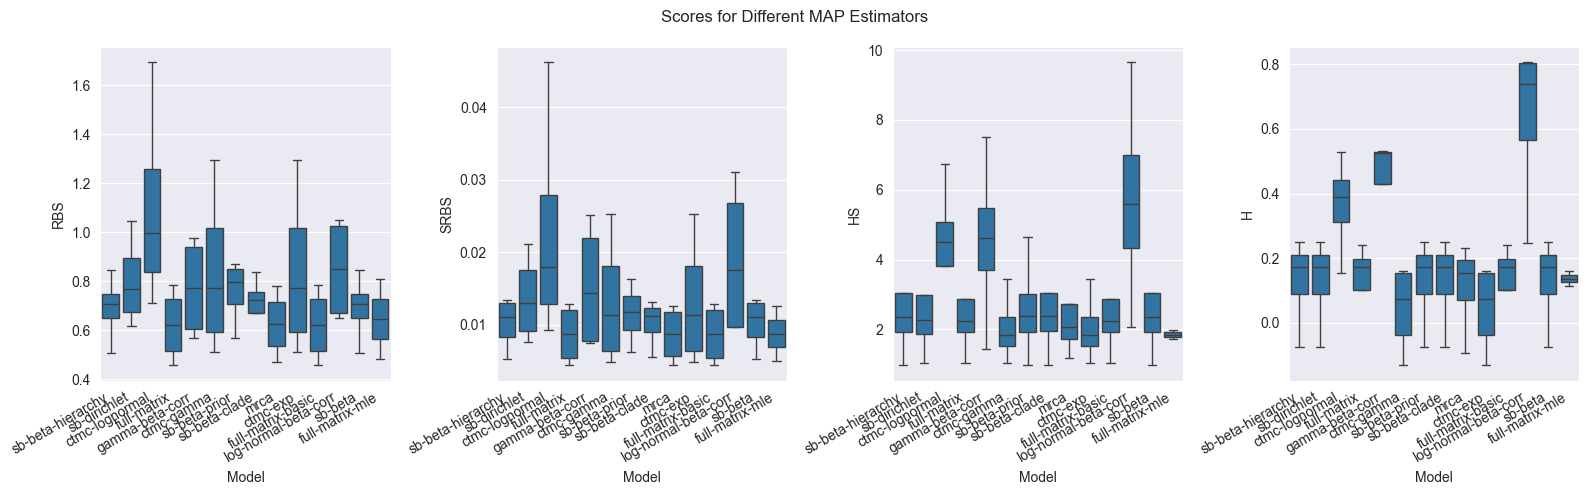

In [50]:
fig, axs = plt.subplots(ncols=NUM_SCORES, figsize=(NUM_SCORES * 4, 5))

for i, score in enumerate(SCORES):
    sns.boxplot(x="model", y=score, data=df_scores, ax=axs[i], fliersize=0, )
    
    axs[i].set_xlabel("Model")
    axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation=30, ha='right')

fig.suptitle("Scores for Different MAP Estimators")
plt.tight_layout()

In [51]:
df_scores

,model,dataset,run,RBS,SRBS,HS,H
0,sb-beta-hierarchy,yule-50,4,0.509403,0.005217,2.469665,0.197808
1,sb-dirichlet,yule-50,4,0.619555,0.007637,2.398651,0.197808
2,ctmc-lognormal,yule-50,4,0.712448,0.009208,4.489234,0.529215
3,full-matrix,yule-50,4,0.457086,0.004366,2.231681,0.184719
4,gamma-beta-corr,yule-50,4,0.568450,0.007429,4.459942,0.531038
5,ctmc-gamma,yule-50,4,0.511811,0.004811,1.999059,0.154581
6,sb-beta-prior,yule-50,4,0.567633,0.006266,2.485708,0.197808
7,sb-beta-clade,yule-50,4,0.517662,0.005513,2.492507,0.197808
8,mrca,yule-50,4,0.470273,0.004439,2.207980,0.182833
9,ctmc-exp,yule-50,4,0.511811,0.004811,1.999059,0.154581
